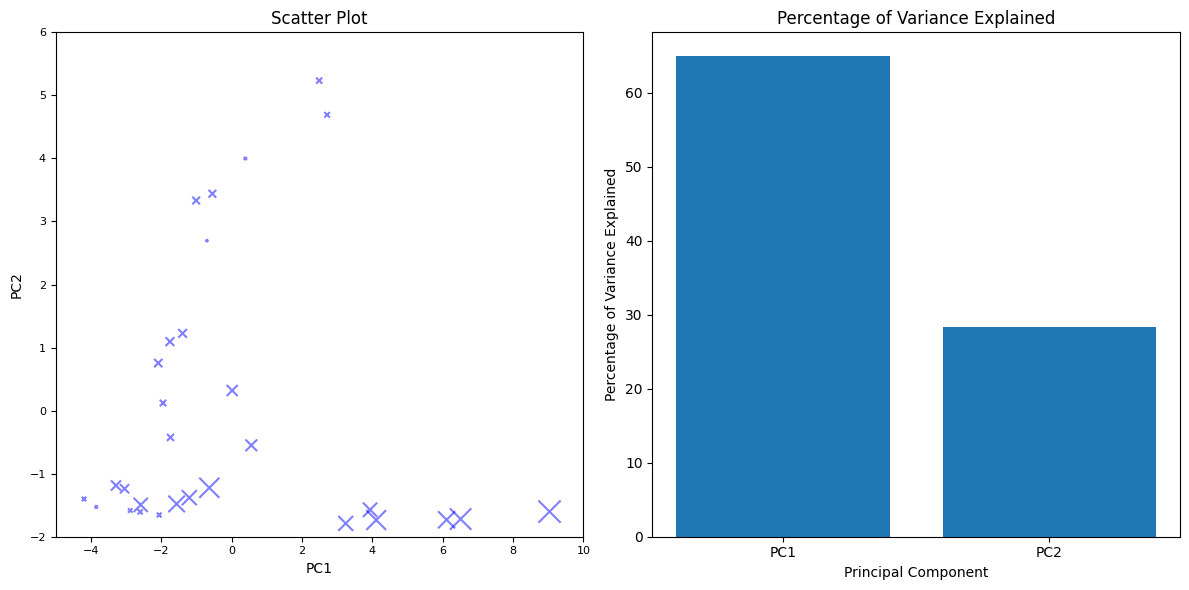

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 
import shap
import xgboost as xgb

from distfit import distfit

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RESPONSE_VARS = ['Limonene']

INPUT_VARS = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                   'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                   'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU']

DBTL_A = ['2X-Mh', 'B-Lm', '2X-Ll', 'A-Mm', 'B-Ll', 'A-Mh', '2X-Lm',
       'A-Hl', '2X-Hh', 'B-Ml', 'B-Mm', '2X-Lh', 'B-Mh', '2X-Hl', 'B-Hl',
       '2X-Ml', 'B-Hm', 'B-Lh', 'B-Hh', 'A-Ll', 'A-Hm', '2X-Mm', 'A-Hh',
       'A-Ml', 'A-Lm',  'A-Lh', '2X-Hm']

DBTL_B = ['BL-Mm', 'BL-Mh', 'BL-Ml']

df = pd.read_csv('../data/preprocessed_data.csv', index_col=0)
data_A = pd.read_csv('../data/data_A.csv', index_col=0)
data_B = pd.read_csv('../data/data_B.csv', index_col=0)

X_train = data_A[INPUT_VARS]
y_train = data_A[RESPONSE_VARS].values.ravel()
X_test = data_B[INPUT_VARS]
y_test = data_B[RESPONSE_VARS].values.ravel()

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA on the training data
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(df.drop('Limonene', axis=1)), columns=['PC1', 'PC2'])
pca_df.index = df.index
pca_df['Limonene'] = df['Limonene']

def plot_pca(pca_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].scatter(pca_df['PC1'], pca_df['PC2'], s=pca_df['Limonene']*2, color='blue', marker='x', alpha=0.5)
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].set_xlim([-5, 10])
    axes[0].set_ylim([-2, 6])
    axes[0].tick_params(labelsize=8)
    axes[0].set_title('Scatter Plot')
    pc_var = pca.explained_variance_ratio_
    pc_var = np.round(pc_var * 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(pc_var)+1)]
    axes[1].bar(x=range(1, len(pc_var)+1), height=pc_var, tick_label=labels)
    axes[1].set_ylabel('Percentage of Variance Explained')
    axes[1].set_xlabel('Principal Component')
    axes[1].set_title('Percentage of Variance Explained')
    plt.tight_layout()
    plt.show()

plot_pca(pca_df)

AVG(RMSE) = 20.81871147344598


100%|██████████| 27/27 [00:02<00:00, 12.31it/s]


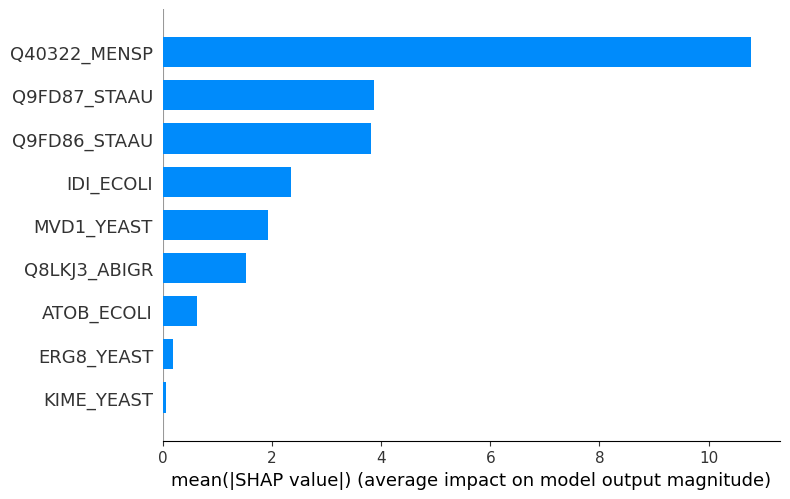

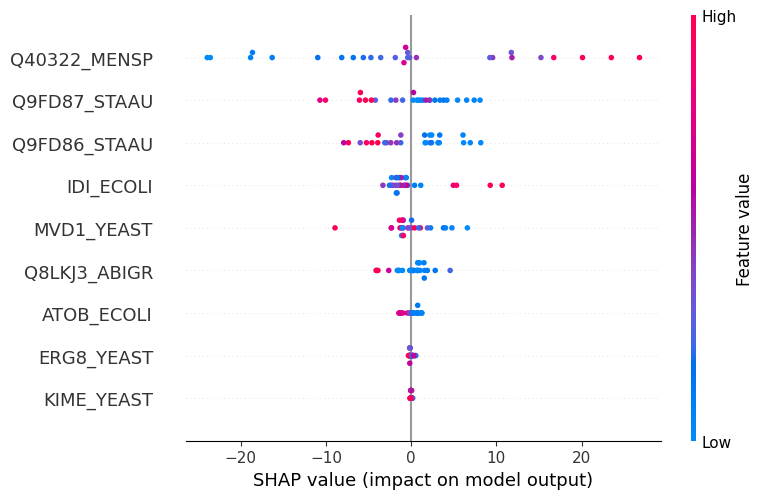

In [43]:
# SVR model
def objective(trial):
    c = trial.suggest_loguniform('C', 1e-3, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-4, 1)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e2)
    svr = SVR(C=c, epsilon=epsilon, gamma=gamma)
    return -np.mean(cross_val_score(svr, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=5))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
best_svr = SVR(**study.best_params)

score = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
best_svr.fit(X_train, y_train)
print(f'AVG(RMSE) = {np.sqrt(np.abs(score.mean()))}')

explainer = shap.KernelExplainer(best_svr.predict, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')
shap.summary_plot(shap_values, X_train, plot_type='dot')

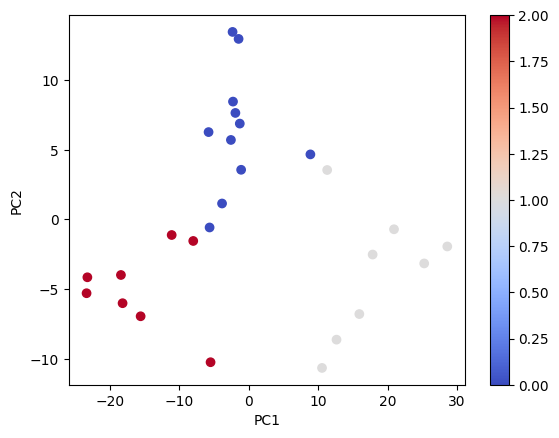

In [44]:
# Perform supervised clustering on shape values to find groups of similar compounds
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(shap_values)
kmeans.labels_

pca_shap = PCA(n_components=2)
pca_shap.fit(shap_values)
X_pca = pca_shap.transform(shap_values)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

y_train = pd.DataFrame(y_train)
y_train.index = X_train.index
y_train['cluster'] = kmeans.labels_
y_train.sort_values(by='cluster', inplace=True)
X_train_cluster_2 = X_train[y_train['cluster'] == 2]

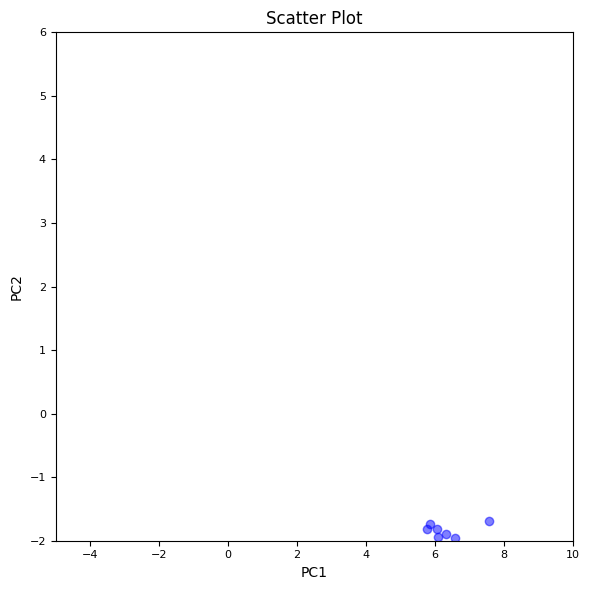

In [65]:
for row in range(len(X_train_cluster_2)):
    X_train_cluster_2.iloc[row]['Q40322_MENSP'] = np.random.uniform(10, 13)
    X_train_cluster_2.iloc[row]['Q9FD87_STAU'] = np.random.uniform(0, 1)
    X_train_cluster_2.iloc[row]['Q9FD86_STAAU'] = np.random.uniform(0, .52)
    X_train_cluster_2.iloc[row]['IDI_ECOLI'] = np.random.uniform(1, 2)
    X_train_cluster_2.iloc[row]['MVD1_YEAST'] = np.random.uniform(1.5, 4)
    X_train_cluster_2.iloc[row]['Q8LKJ3_ABIGR'] = np.random.uniform(0, 1)
    X_train_cluster_2.iloc[row]['ATOB_ECOLI'] = np.random.uniform(1, 2)
    X_train_cluster_2.iloc[row]['KIME_YEAST'] = np.random.uniform(0.3, 1.4)
    X_train_cluster_2.iloc[row]['ERG8_YEAST'] = np.random.uniform(0, 1)

X_train_cluster_2 = X_train_cluster_2[pca.feature_names_in_]

# PCA plot
new_pca_df = pd.DataFrame(pca.transform(X_train_cluster_2), columns=['PC1', 'PC2'])
new_pca_df.index = X_train_cluster_2.index
# Plot the PCA
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(new_pca_df['PC1'], new_pca_df['PC2'], color='blue', marker='o', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_xlim([-5, 10])
ax.set_ylim([-2, 6])
ax.tick_params(labelsize=8)
ax.set_title('Scatter Plot')
plt.tight_layout()
plt.show()

In [61]:
X_train_cluster_2[X_test.columns.values]

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
2X-Ll,0.749900,0.4691,1.645821,0.983126,1.745285,12.036955,2.790236,0.518675,0.887836
A-Hl,1.164811,0.7214,1.460878,0.484647,1.321613,12.099120,1.894768,0.451091,0.767529
2X-Hl,1.256691,0.3407,1.993426,0.288904,1.336233,12.502188,3.947309,0.366114,0.005103
B-Hl,0.915374,0.1939,1.207227,0.142349,1.230699,12.447800,2.170679,0.082595,0.665092
2X-Ml,0.769535,0.3804,1.595439,0.086662,1.384402,11.080190,1.628374,0.119126,0.047277
B-Hm,0.537609,0.2390,1.014443,0.018281,1.052445,11.907987,1.508645,0.257742,0.485791
B-Hh,0.683601,0.2486,1.003799,0.181496,1.877703,12.160360,3.495398,0.025152,0.290626
2X-Hm,0.688175,0.1899,1.671839,0.904886,1.144860,11.959261,3.640301,0.487441,0.701940


In [62]:
data_B

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
BL-Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367
BL-Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494
BL-Ml,0.24012,0.19050,0.94884,0.38070,1.30811,2.72406,0.11237,0.05002,0.08503,6.72018


In [47]:
1/0

ZeroDivisionError: division by zero

In [ ]:
X_train_cluster_2

In [ ]:
# Create a dataframe similar to X_train but empty
X_design = pd.DataFrame(columns=X_train.columns)



# Add a row of values with values from a list of values
X_design.loc[0] = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 2, 3]

In [ ]:
# Generate synthetic data for each feature
X_synthetic = pd.DataFrame()
for col in X_train.columns:
    dist = distfit()
    dist.fit_transform(X_train[col].values, verbose=0)
    X_synthetic[col] = dist.generate(n=1000)  # Produce synthetic data from the given distribution fitted by distfit

# Drop rows with negative values
X_synthetic = X_synthetic[(X_synthetic > 0).all(axis=1)]
X_synthetic['Limonene'] = best_svr.predict(X_synthetic)
print(f'X_synthetic shape: {X_synthetic.shape}')    